In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os

drive_path = '/content/drive/MyDrive/BERT_for_Disaster_Classification'
print(os.listdir(drive_path))

['Disaster_Tweets_Project', 'BERT_Models', 'Dataset2_not_used_yet', 'Dataset1_used', 'Disasters_Articles_Project']


# Co-occurence

USING SPACY MODEL

In [3]:
import pandas as pd
import spacy
import torch
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import time
from math import log

# Configuration
DATA_PATH = "/content/drive/MyDrive/BERT_for_Disaster_Classification/Disaster_Tweets_Project/validation_dataset.csv"
ADVERSE_NOUNS = {"hurricane", "flood", "earthquake", "bombing", "disaster", "storm", "explosion", "tsunami", "wildfire", "tornado", "landslide", "famine", "drought", "avalanche", "blizzard", "cyclone", "epidemic", "pandemic", "collapse", "crash", "outbreak", "typhoon", "monsoon", "evacuation", "looting", "blackout", "contagion", "malfunction", "displacement", "hostage", "radiation", "sabotage", "arson", "inferno", "derailment", "collision", "contamination", "inundation", "plague", "upheaval", "insurgency", "terrorism", "vandalism", "recession", "infestation", "starvation", "stranding", "implosion", "incursion", "biohazard", "flooding"}
ADVERSE_ADJECTIVES = {"severe", "deadly", "devastating", "dangerous", "massive", "destructive", "violent", "catastrophic", "extreme", "intense", "widespread", "raging", "powerful", "critical", "hazardous", "lethal", "fatal", "calamitous", "uncontrollable", "worsening", "threatening", "imminent", "cataclysmic", "ruinous", "debilitating", "perilous", "volatile", "dire", "harrowing", "ravaging", "devastated", "unstable", "toxic", "suffocating", "blistering", "paralyzing", "submerged", "contaminated", "incendiary", "uninhabitable", "apocalyptic", "excruciating", "unbearable", "shattered", "infectious", "corrosive", "decimated", "stranded", "overwhelmed", "collapsed", "isolated", "unrelenting", "disastrous", "crippling"}
ADVERSE_TERMS = ADVERSE_NOUNS.union(ADVERSE_ADJECTIVES)
BATCH_SIZE = 512
WINDOW_SIZE = 5

# Initialize spaCy with GPU
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm", disable=["lemmatizer", "ner", "textcat"])

# Initialize CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# Data Loading and Cleaning
print("Loading and preprocessing data...")
df = pd.read_csv(DATA_PATH)
df = df[df['label'] == 1]
df['text'] = df['text'].fillna('').str.lower()

# Calculate total number of tokens for N
total_tokens = df['text'].apply(lambda x: len(x.split())).sum()
print(f"Total tokens in corpus (N): {total_tokens}")

# Initialize tracking structures
word2idx = {}
idx2word = {}
cooccurrence = defaultdict(int)
term_freq = defaultdict(int)

def process_batch(texts, progress):
    """Process a batch of texts using the original noun chunk logic"""
    docs = nlp.pipe(texts, batch_size=BATCH_SIZE, n_process=1)
    batch_cooccurrence = defaultdict(int)

    for doc in docs:
        chunks = []
        for chunk in doc.noun_chunks:
            root = chunk.root.text.lower()
            if root in ADVERSE_TERMS:
                clean_chunk = chunk.text.lower().replace(" ", "_")
                chunks.append(clean_chunk)

        if chunks:
            indices = []
            for chunk in chunks:
                # Find adverse subwords within the identified chunk
                subwords = [sw for sw in chunk.split("_") if sw in ADVERSE_TERMS]
                for sw in subwords:
                    if sw not in word2idx:
                        idx = len(word2idx)
                        word2idx[sw] = idx
                        idx2word[idx] = sw
                    indices.append(word2idx[sw])
                    term_freq[word2idx[sw]] += 1

            if len(indices) > 1:
                indices_tensor = torch.tensor(indices, device=device)
                n = len(indices_tensor)
                for i in range(n):
                    start = max(0, i - WINDOW_SIZE)
                    end = min(n, i + WINDOW_SIZE + 1)
                    window = torch.cat([indices_tensor[start:i], indices_tensor[i+1:end]])
                    if len(window) > 0:
                        center = indices_tensor[i]
                        pairs = torch.stack([center.repeat(len(window)), window]).T
                        unique_pairs, counts = torch.unique(pairs, dim=0, return_counts=True)
                        for pair, count in zip(unique_pairs, counts):
                              i_idx, j_idx = pair[0].item(), pair[1].item()
                              sorted_pair = tuple(sorted((idx2word[i_idx], idx2word[j_idx])))
                              if sorted_pair[0] != sorted_pair[1]:
                                  batch_cooccurrence[sorted_pair] += count.item()
        progress.update(1)
    return batch_cooccurrence

# Main processing loop
print("\nProcessing texts...")
texts = df['text'].tolist()
with tqdm(total=len(texts), desc="Documents") as pbar:
    for i in range(0, len(texts), BATCH_SIZE):
        batch = texts[i:i+BATCH_SIZE]
        batch_cooc = process_batch(batch, pbar)
        for pair, count in batch_cooc.items():
            cooccurrence[pair] += count

# Calculate metrics
print("\nCalculating statistics...")
metrics = []
seen_pairs = set()
N = total_tokens

for (term1, term2), count in tqdm(cooccurrence.items(), desc="Calculating Metrics"):
    if (term1, term2) in seen_pairs:
        continue
    seen_pairs.add((term1, term2))

    try:
        a = count
        b = term_freq[word2idx[term1]] - a
        c = term_freq[word2idx[term2]] - a
        d = N - (a + b + c)

        if a < 0 or b < 0 or c < 0 or d < 0: continue

        pmi = log((a * N) / ((a + b) * (a + c)) + 1e-9) if a > 0 and (a + b) > 0 and (a + c) > 0 else 0
        dice = (2 * a) / (2*a + b + c) if (2*a + b + c) > 0 else 0
        log_like = 2 * (a*log(a) + b*log(b) + c*log(c) + d*log(d) - (a+b)*log(a+b) - (a+c)*log(a+c) - (b+d)*log(b+d) - (c+d)*log(c+d) + N*log(N)) if all(x > 0 for x in [a,b,c,d]) else 0

        metrics.append({
            'Term1': term1, 'Term2': term2, 'Cooccurrence': count,
            'PMI': round(pmi, 2), 'Dice': round(dice, 2), 'LogLikelihood': round(log_like, 2)
        })
    except (KeyError, ValueError):
        continue

# Create and save DataFrame
df_metrics = pd.DataFrame(metrics)
df_filtered = df_metrics.sort_values('LogLikelihood', ascending=False)

print("\nTop Co-occurrences ranked by LLR:")
print(df_filtered.head(10))

df_filtered.to_csv('spacy_cooccurrence.csv', index=False)
print("\nSaved results to spacy_cooccurrence.csv")

Loading and preprocessing data...
Total tokens in corpus (N): 466592

Processing texts...


Documents: 100%|██████████| 20549/20549 [00:40<00:00, 503.14it/s]



Calculating statistics...


Calculating Metrics: 100%|██████████| 141/141 [00:00<00:00, 37236.93it/s]



Top Co-occurrences ranked by LLR:
          Term1       Term2  Cooccurrence   PMI  Dice  LogLikelihood
6    earthquake     tsunami           102  5.85  0.15        1160.75
1    earthquake     massive            64  5.78  0.10         703.66
5     explosion     massive            60  6.20  0.14         701.71
4       bombing   explosion            54  5.22  0.11         479.02
0      flooding     monsoon            32  7.26  0.22         440.49
17  devastating     tornado            36  6.38  0.13         421.19
22     disaster       flood            34  6.16  0.16         367.21
31       deadly  derailment            26  7.06  0.25         330.49
13       deadly     monsoon            22  8.01  0.36         329.46
2        deadly   explosion            34  5.54  0.08         327.05

Saved results to spacy_cooccurrence.csv


In [4]:
print(df_filtered)

         Term1      Term2  Cooccurrence   PMI  Dice  LogLikelihood
6   earthquake    tsunami           102  5.85  0.15        1160.75
1   earthquake    massive            64  5.78  0.10         703.66
5    explosion    massive            60  6.20  0.14         701.71
4      bombing  explosion            54  5.22  0.11         479.02
0     flooding    monsoon            32  7.26  0.22         440.49
..         ...        ...           ...   ...   ...            ...
16  earthquake      storm             2  1.32  0.00           2.36
70  earthquake   flooding             2  1.10  0.00           1.75
47   explosion    tornado             2  0.87  0.00           1.17
42  earthquake    tornado             2  0.40  0.00           0.28
49     tornado    violent             6  6.83  0.02           0.00

[125 rows x 6 columns]


USING CUSTOM BERT MODEL

In [5]:
import pandas as pd
import torch
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import time
from math import log
from transformers import BertForSequenceClassification, AutoTokenizer

# Configuration
DATA_PATH = "/content/drive/MyDrive/BERT_for_Disaster_Classification/Disaster_Tweets_Project/validation_dataset.csv"
ADVERSE_NOUNS = {"hurricane", "flood", "earthquake", "bombing", "disaster", "storm", "explosion", "tsunami", "wildfire", "tornado", "landslide", "famine", "drought", "avalanche", "blizzard", "cyclone", "epidemic", "pandemic", "collapse", "crash", "outbreak", "typhoon", "monsoon", "evacuation", "looting", "blackout", "contagion", "malfunction", "displacement", "hostage", "radiation", "sabotage", "arson", "inferno", "derailment", "collision", "contamination", "inundation", "plague", "upheaval", "insurgency", "terrorism", "vandalism", "recession", "infestation", "starvation", "stranding", "implosion", "incursion", "biohazard", "flooding"}
ADVERSE_ADJECTIVES = {"severe", "deadly", "devastating", "dangerous", "massive", "destructive", "violent", "catastrophic", "extreme", "intense", "widespread", "raging", "powerful", "critical", "hazardous", "lethal", "fatal", "calamitous", "uncontrollable", "worsening", "threatening", "imminent", "cataclysmic", "ruinous", "debilitating", "perilous", "volatile", "dire", "harrowing", "ravaging", "devastated", "unstable", "toxic", "suffocating", "blistering", "paralyzing", "submerged", "contaminated", "incendiary", "uninhabitable", "apocalyptic", "excruciating", "unbearable", "shattered", "infectious", "corrosive", "decimated", "stranded", "overwhelmed", "collapsed", "isolated", "unrelenting", "disastrous", "crippling"}
ADVERSE_TERMS = ADVERSE_NOUNS.union(ADVERSE_ADJECTIVES)
BATCH_SIZE = 32
WINDOW_SIZE = 5

# Load BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/BERT_for_Disaster_Classification/Disaster_Tweets_Project/my_bert_model2/')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/BERT_for_Disaster_Classification/Disaster_Tweets_Project/my_bert_model2/')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Data Loading and Cleaning
print("Loading and preprocessing data...")
df = pd.read_csv(DATA_PATH)
df['text'] = df['text'].fillna('').str.lower()

# Calculate total number of tokens for N
total_tokens = df['text'].apply(lambda x: len(x.split())).sum()
print(f"Total tokens in corpus (N): {total_tokens}")

# Initialize tracking structures
word2idx = {}
idx2word = {}
cooccurrence = defaultdict(int)
term_freq = defaultdict(int)

def process_batch_bert(texts, progress):
    """Process a batch of texts using the original BERT tokenizer logic"""
    batch_cooccurrence = defaultdict(int)

    for text in texts:
        words = [token[0] for token in tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)]
        words = [w.lower() for w in words]

        indices = []
        for word in words:
            if word in ADVERSE_TERMS:
                if word not in word2idx:
                    idx = len(word2idx)
                    word2idx[word] = idx
                    idx2word[idx] = word
                indices.append(word2idx[word])
                term_freq[word2idx[word]] += 1

        if len(indices) > 1:
            indices_tensor = torch.tensor(indices, device=device)
            n = len(indices_tensor)
            for i in range(n):
                start = max(0, i - WINDOW_SIZE)
                end = min(n, i + WINDOW_SIZE + 1)
                window = torch.cat([indices_tensor[start:i], indices_tensor[i+1:end]])
                if len(window) > 0:
                    center = indices_tensor[i]
                    pairs = torch.stack([center.repeat(len(window)), window]).T
                    unique_pairs, counts = torch.unique(pairs, dim=0, return_counts=True)
                    for pair, count in zip(unique_pairs, counts):
                        i_idx, j_idx = pair[0].item(), pair[1].item()
                        sorted_pair = tuple(sorted((idx2word[i_idx], idx2word[j_idx])))
                        if sorted_pair[0] != sorted_pair[1]:
                            batch_cooccurrence[sorted_pair] += count.item()
        progress.update(1)
    return batch_cooccurrence

# Main processing loop
print("\nProcessing texts...")
texts = df['text'].tolist()
with tqdm(total=len(texts), desc="Documents") as pbar:
    for i in range(0, len(texts), BATCH_SIZE):
        # We send a batch of texts to the function
        batch_texts = texts[i:i+BATCH_SIZE]
        batch_cooc = process_batch_bert(batch_texts, pbar)
        for pair, count in batch_cooc.items():
            cooccurrence[pair] += count

# Calculate metrics
print("\nCalculating statistics...")
metrics = []
seen_pairs = set()
N = total_tokens

for (term1, term2), count in tqdm(cooccurrence.items(), desc="Calculating Metrics"):
    if (term1, term2) in seen_pairs:
        continue
    seen_pairs.add((term1, term2))

    try:
        a = count
        b = term_freq[word2idx[term1]] - a
        c = term_freq[word2idx[term2]] - a
        d = N - (a + b + c)

        if a < 0 or b < 0 or c < 0 or d < 0: continue

        pmi = log((a * N) / ((a + b) * (a + c)) + 1e-9) if a > 0 and (a + b) > 0 and (a + c) > 0 else 0
        dice = (2 * a) / (2*a + b + c) if (2*a + b + c) > 0 else 0
        log_like = 2 * (a*log(a) + b*log(b) + c*log(c) + d*log(d) - (a+b)*log(a+b) - (a+c)*log(a+c) - (b+d)*log(b+d) - (c+d)*log(c+d) + N*log(N)) if all(x > 0 for x in [a,b,c,d]) else 0

        metrics.append({
            'Term1': term1, 'Term2': term2, 'Cooccurrence': count,
            'PMI': round(pmi, 2), 'Dice': round(dice, 2), 'LogLikelihood': round(log_like, 2)
        })
    except (KeyError, ValueError):
        continue

# Create and save DataFrame
df_metrics = pd.DataFrame(metrics)
df_filtered = df_metrics.sort_values('LogLikelihood', ascending=False)

print("\nTop Co-occurrences ranked by LLR:")
print(df_filtered.head(10))

df_filtered.to_csv('bert_cooccurrence.csv', index=False)
print("\nSaved results to bert_cooccurrence.csv")

Loading and preprocessing data...
Total tokens in corpus (N): 833497

Processing texts...


Documents: 100%|██████████| 40930/40930 [00:10<00:00, 3772.63it/s] 



Calculating statistics...


Calculating Metrics: 100%|██████████| 311/311 [00:00<00:00, 37297.09it/s]


Top Co-occurrences ranked by LLR:
          Term1       Term2  Cooccurrence   PMI  Dice  LogLikelihood
24   earthquake    powerful           156  5.94  0.14        1803.20
34    hurricane       storm           134  4.96  0.10        1132.91
58  devastating  earthquake            94  5.61  0.09         956.35
3    earthquake     massive            94  5.42  0.09         900.62
69     disaster       flood            86  5.28  0.11         774.43
12    explosion     massive            72  5.99  0.14         760.88
9       bombing   explosion            74  5.40  0.12         677.19
0        deadly     monsoon            46  7.44  0.26         631.80
16        flood    flooding            74  4.79  0.09         581.73
2      flooding     monsoon            44  7.04  0.19         564.40

Saved results to bert_cooccurrence.csv


**Co-Occurence Graphs**

In [6]:
!pip install adjustText

In [7]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from adjustText import adjust_text

def create_cooccurrence_graph(df, title, filename, node_color, top_n=None):
    """
    Creates a co-occurrence graph with a specified uniform node color.
    """
    print(f"Creating graph: {title}...")

    # 1. --- DATA PREPARATION ---
    graph_df = df.sort_values('LogLikelihood', ascending=False).head(top_n)
    if graph_df.empty:
        print("DataFrame is empty. Cannot create graph.")
        return
    G = nx.from_pandas_edgelist(graph_df, 'Term1', 'Term2', edge_attr='LogLikelihood')

    # 2. --- STYLING AND LAYOUT ---
    pos = nx.spring_layout(G, k=3.5, iterations=50, seed=42)

    degrees = dict(G.degree())
    max_degree = max(degrees.values()) if degrees else 1
    node_sizes = [1500 + 5000 * (degrees.get(node, 0) / max_degree) for node in G.nodes()]

    weights = [G[u][v]['LogLikelihood'] for u, v in G.edges()]
    min_w, max_w = min(weights), max(weights)
    edge_widths = [2 + 8 * ((weight - min_w) / (max_w - min_w)) for weight in weights]

    edge_labels = {
        (u, v): f"{weight:.0f}"
        for u, v, data in G.edges(data=True)
        if (weight := data['LogLikelihood']) in [max_w, min_w]
    }

    # 3. --- PLOTTING ---
    fig, ax = plt.subplots(figsize=(20, 16))

    # Use the 'node_color' parameter passed to the function
    nx.draw_networkx_nodes(
        G, pos, node_size=node_sizes, node_color=node_color,
        edgecolors='#333333', linewidths=1.5, alpha=1.0, ax=ax
    )
    nx.draw_networkx_edges(
        G, pos, width=edge_widths, edge_color='#9E9E9E', alpha=0.7, ax=ax
    )

    texts = []
    for node, (x, y) in pos.items():
        texts.append(ax.text(
            x, y, node,
            fontsize=24,
            fontweight='bold',
            ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='gray', alpha=0.8)
        ))

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.7))

    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels, font_size=16, font_color='#212121',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5), ax=ax
    )

    ax.set_title(title, fontsize=28, fontweight='bold', pad=20)
    plt.figtext(
        0.5, 0.08,
        "Node size denotes term importance (connections) | Edge thickness denotes association strength (LogLikelihood)",
        ha="center", fontsize=14, style='italic', color='#555555'
    )

    plt.margins(0.1)
    plt.axis('off')

    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Graph saved to {filename}")
    plt.show()
    plt.close()

In [8]:
# Load co-occurrence data
df_bert = pd.read_csv('bert_cooccurrence.csv')
df_spacy = pd.read_csv('spacy_cooccurrence.csv')

Creating graph: Adverse Term Co-occurrence Network (BERT)...
Graph saved to BERT Graph.png


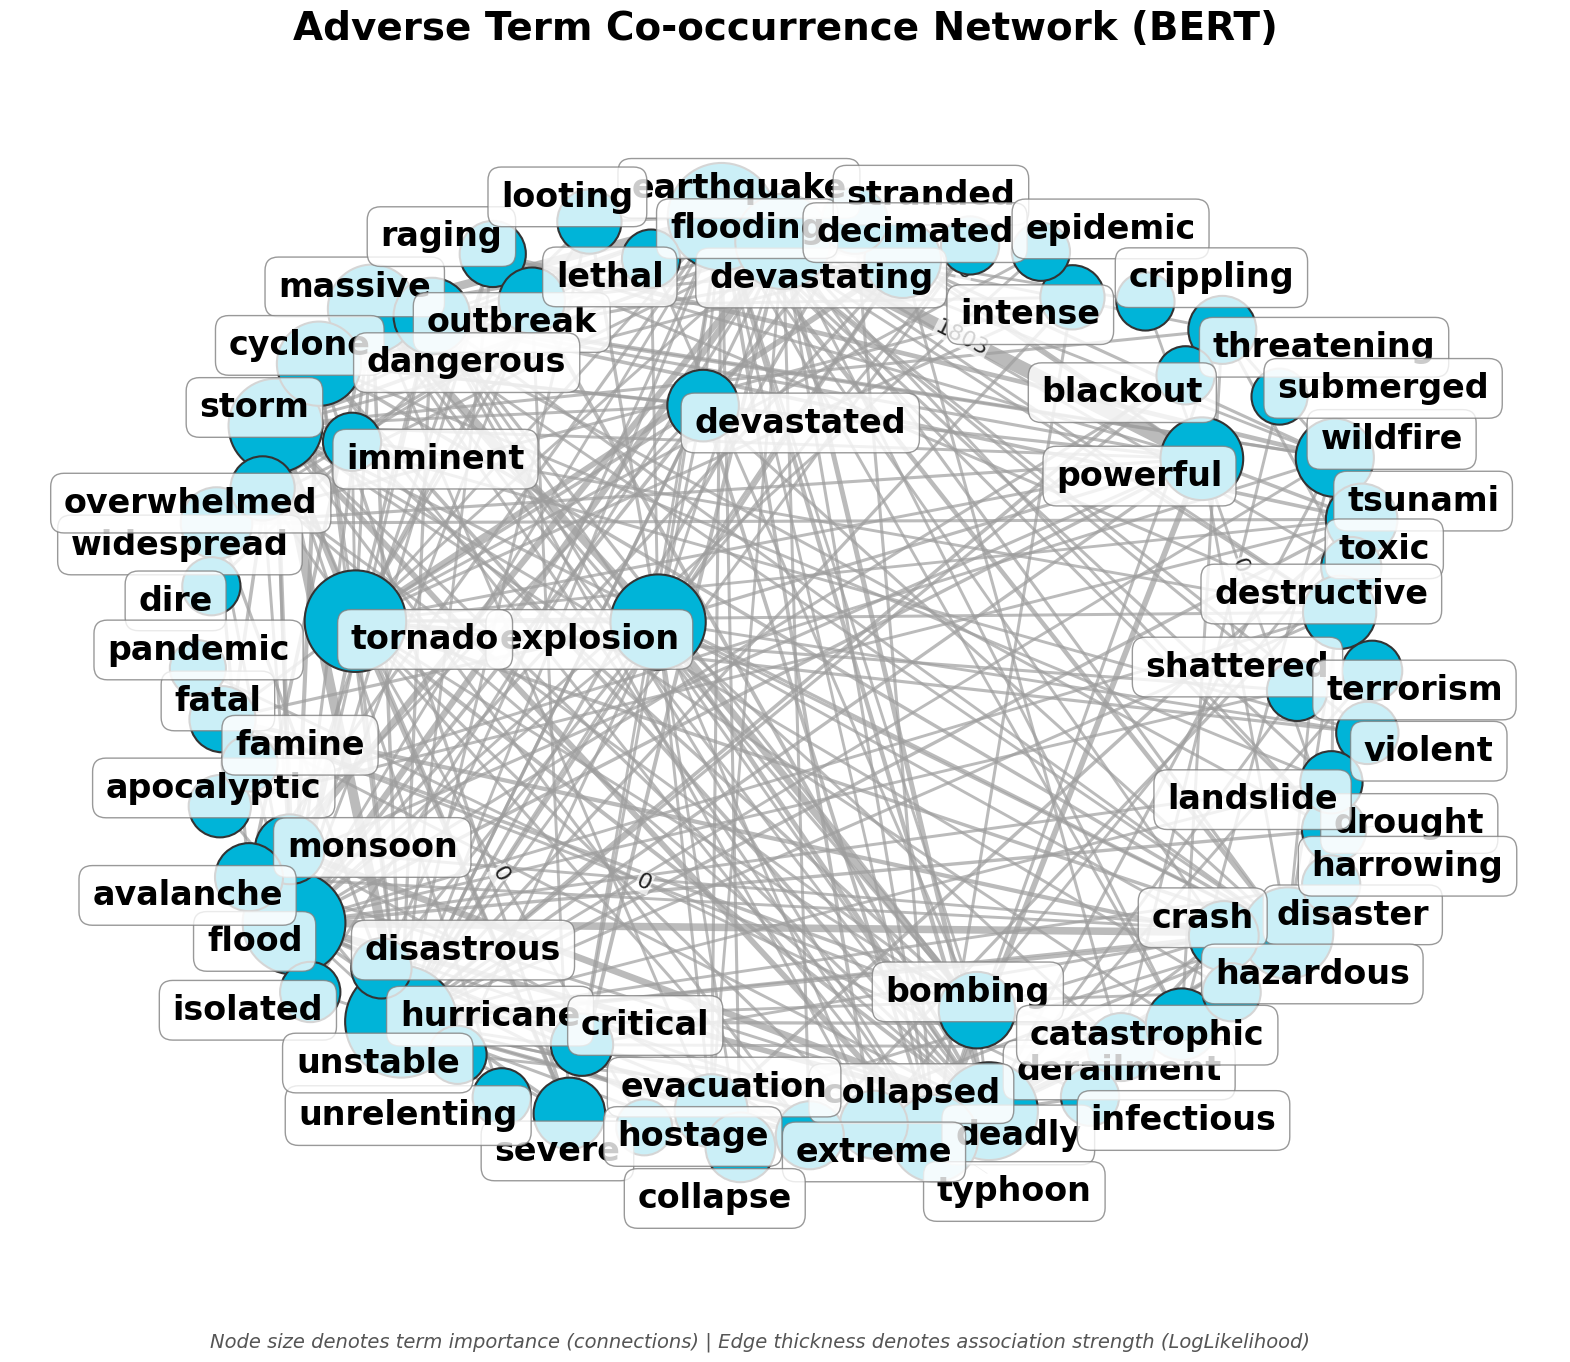

In [9]:
create_cooccurrence_graph(
     df_bert,
     title="Adverse Term Co-occurrence Network (BERT)",
     filename="BERT Graph.png",
     node_color='#00B4D8',  # Blue
 )

Creating graph: Adverse Term Co-occurrence Network (SpaCy)...
Graph saved to Spacy Graph.png


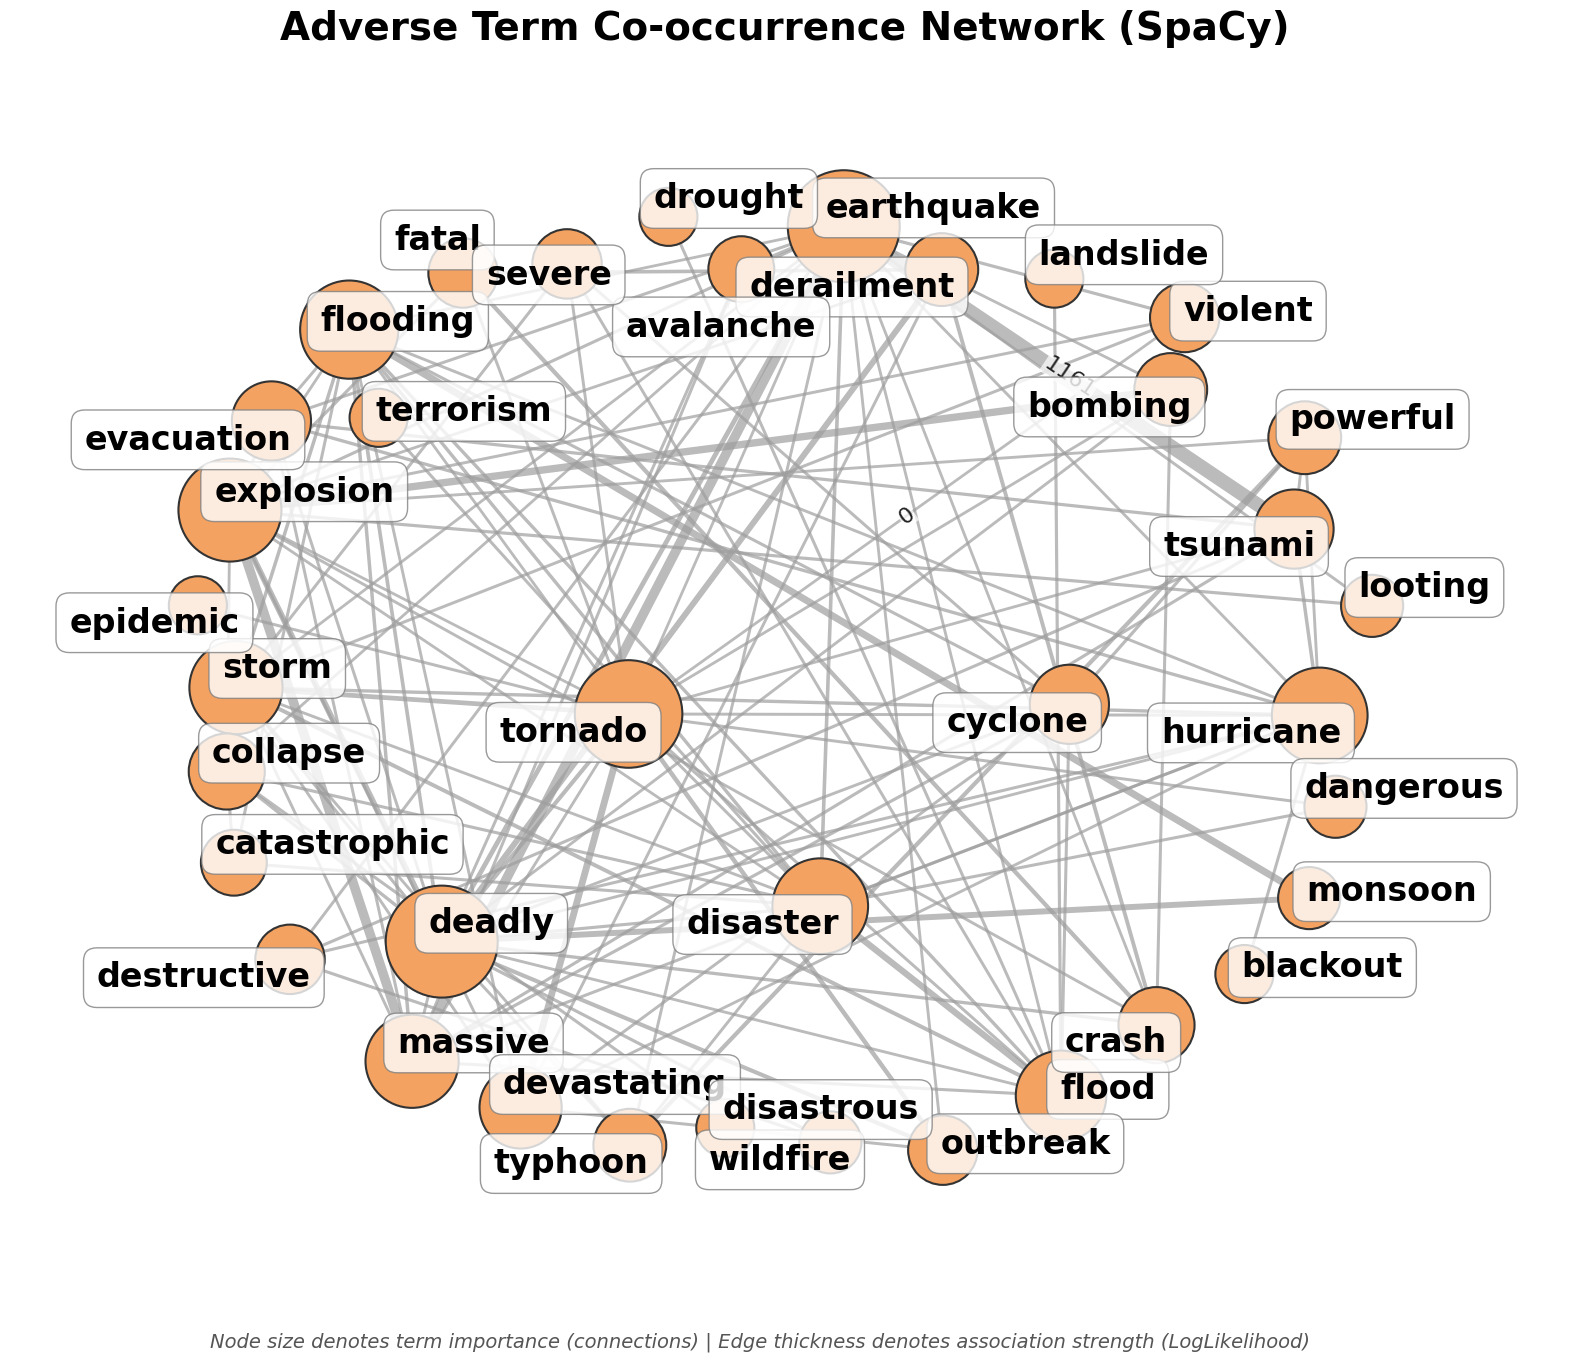

In [10]:
create_cooccurrence_graph(
     df_spacy,
     title="Adverse Term Co-occurrence Network (SpaCy)",
     filename="Spacy Graph.png",
     node_color='#F4A261',  # Orange
)

Creating graph: Adverse Term Co-occurrence Network (BERT) Top 30...
Graph saved to BERT Graph Top 30.png


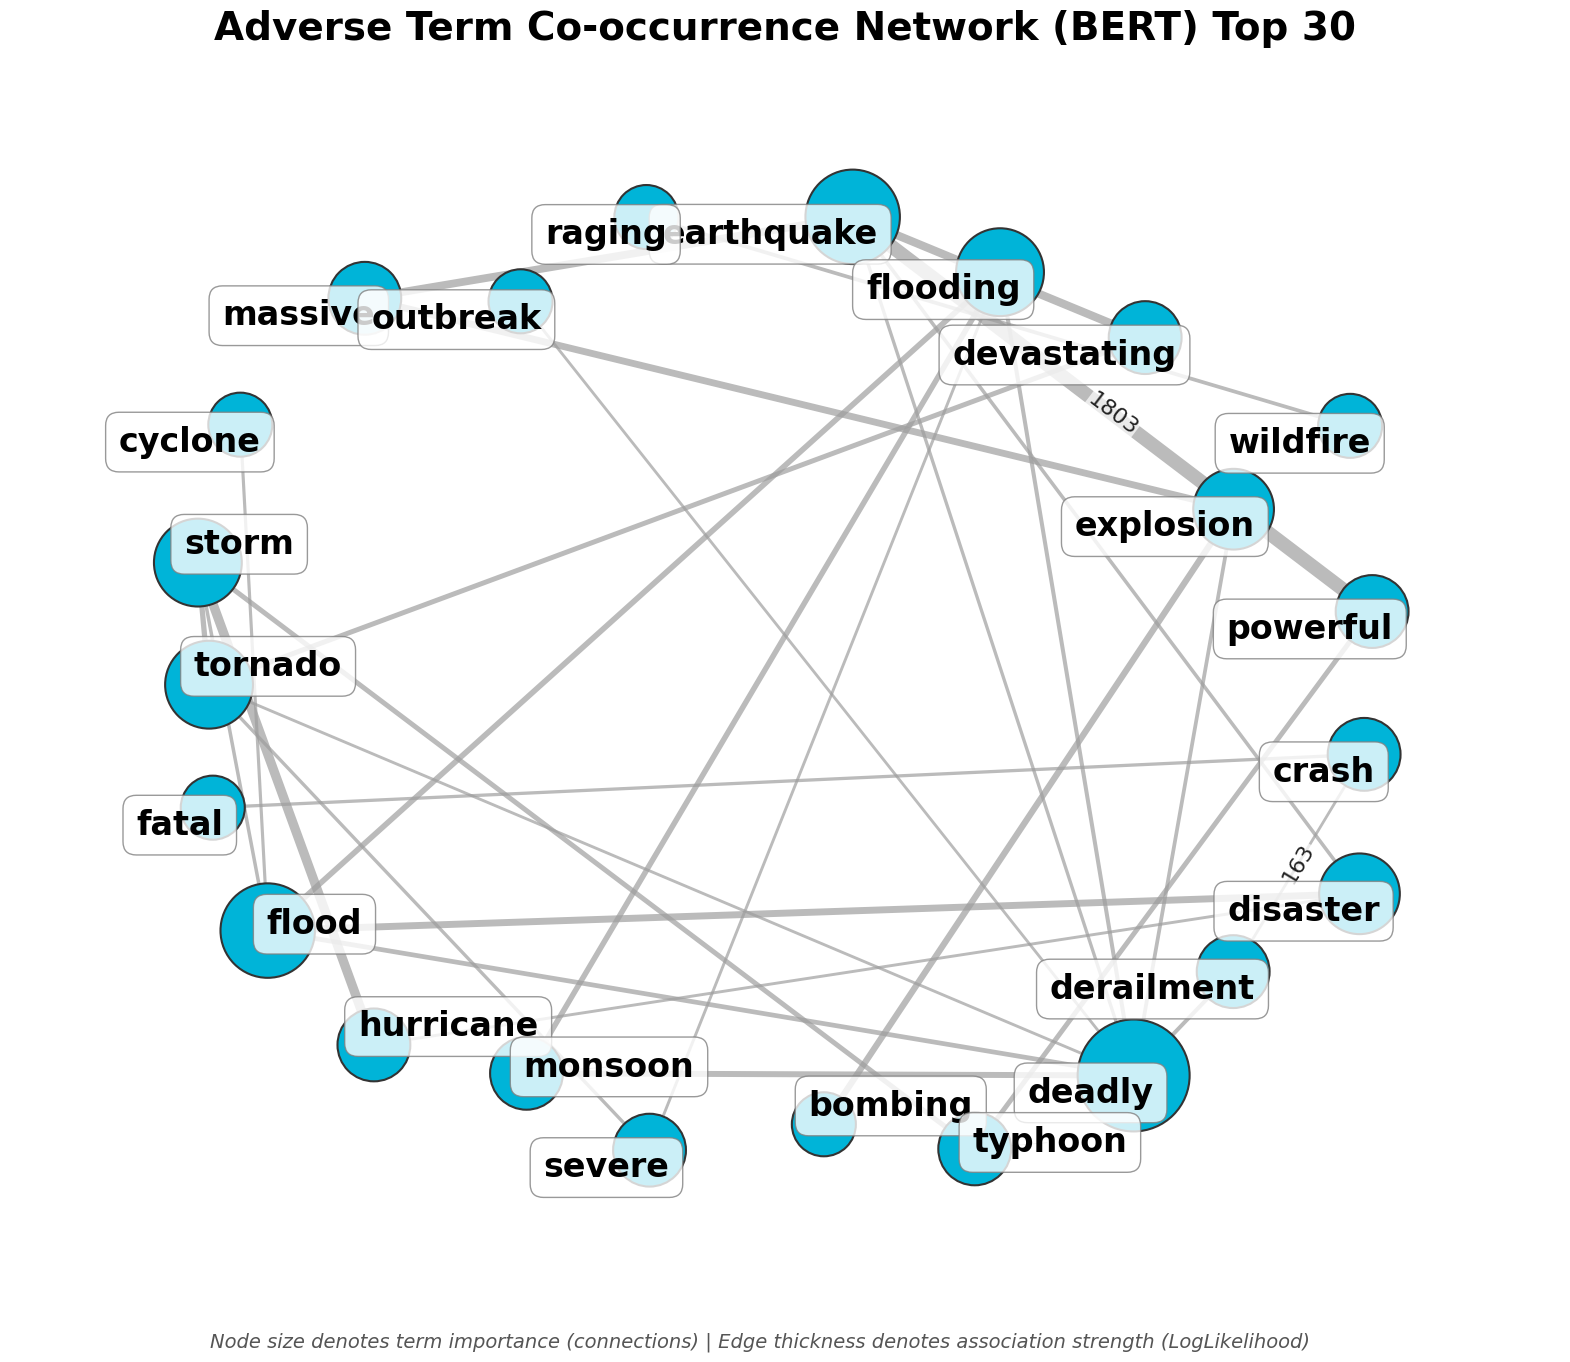

In [11]:
create_cooccurrence_graph(
     df_bert,
     title="Adverse Term Co-occurrence Network (BERT) Top 30",
     filename="BERT Graph Top 30.png",
     node_color='#00B4D8',  # Blue
     top_n=30
 )

Creating graph: Adverse Term Co-occurrence Network (SpaCy) Top 30...
Graph saved to SpaCy Graph Top 30.png


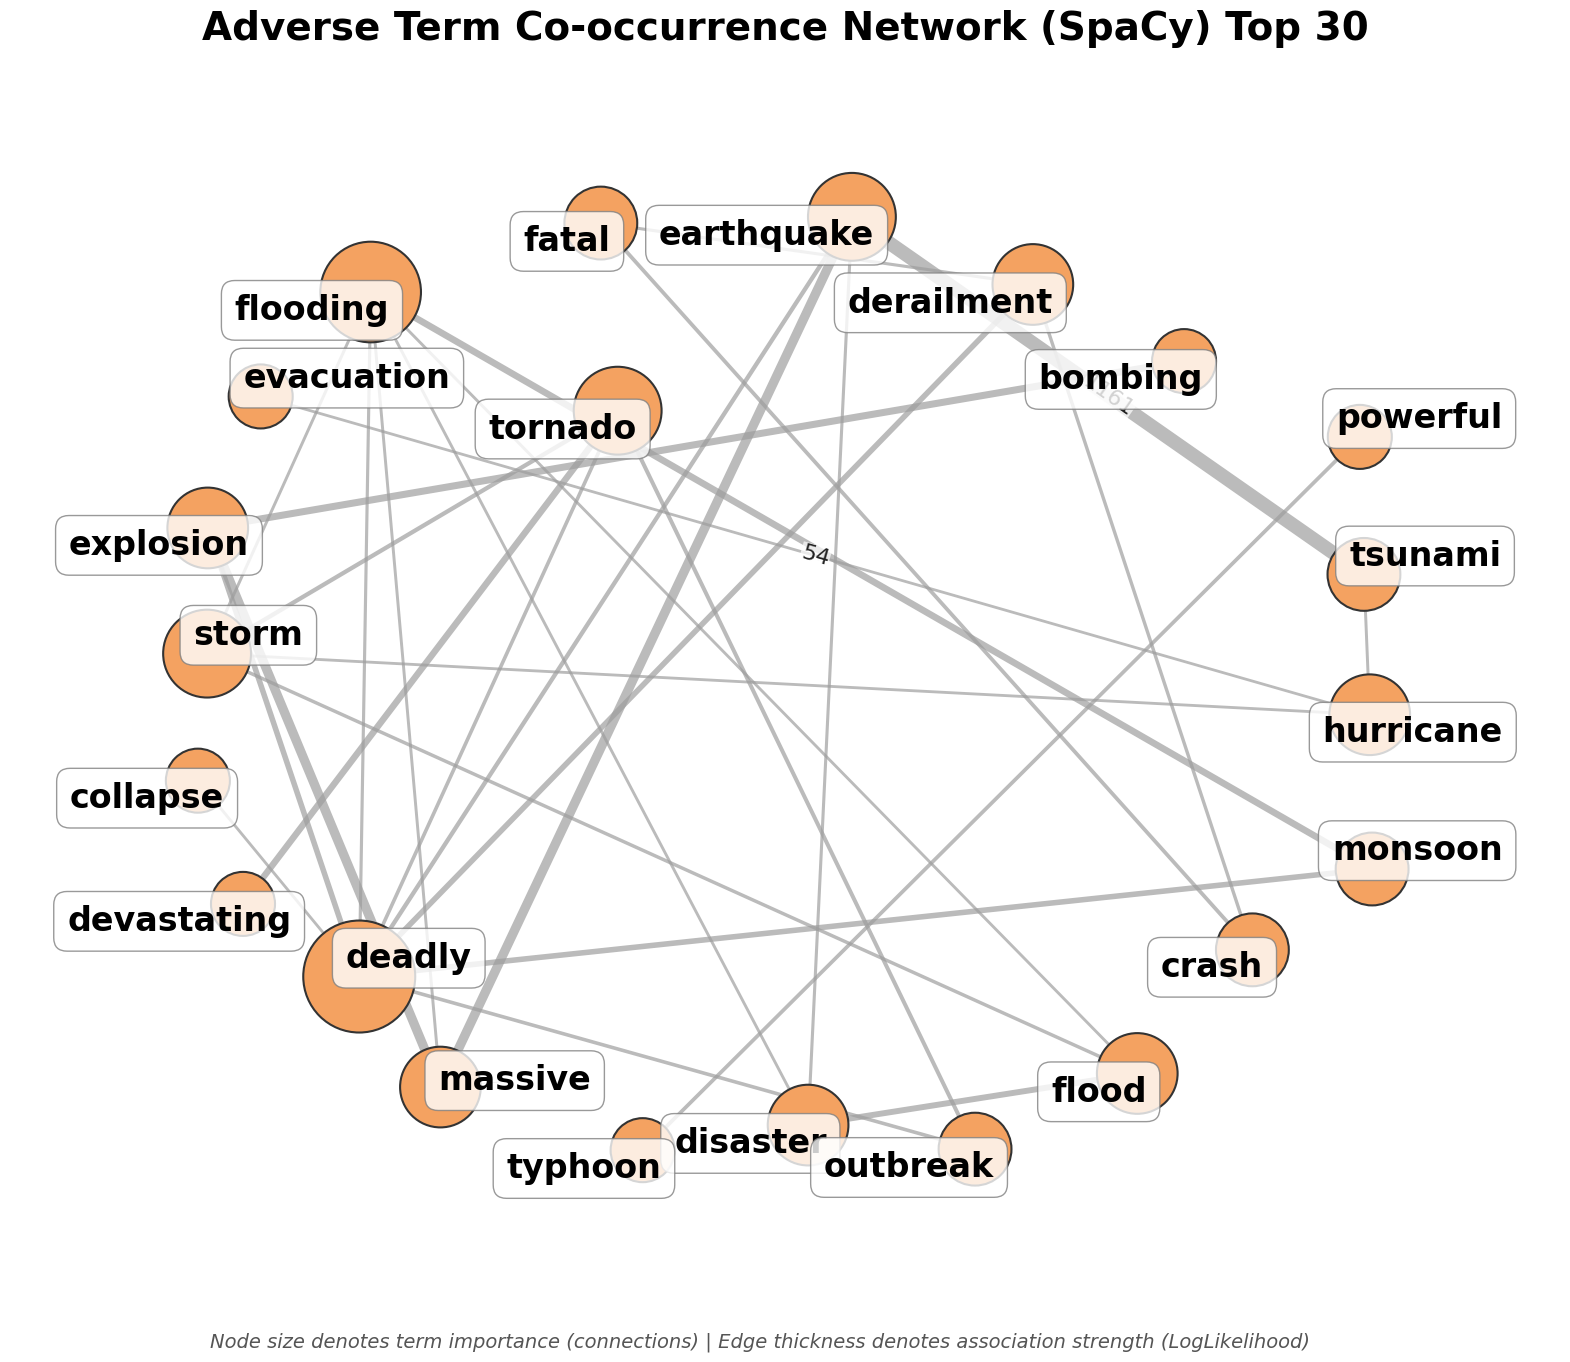

In [12]:
create_cooccurrence_graph(
     df_spacy,
     title="Adverse Term Co-occurrence Network (SpaCy) Top 30",
     filename="SpaCy Graph Top 30.png",
     node_color='#F4A261',  # Orange
     top_n=30
 )